# **Neuropolis: Building an artificial intelligence system for human brain activity prediction (EEG, fMRI)**

#### Version: 10th March 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through nine Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Linear Regression*

*04: KNN, Decision Trees, Random Forests, SVM*

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

***08: Transformers***

*09: Human Brain Predictability Map*

==============================================================================================

### Notebook 08

# **Transformers**

## **1. Classification**

- **Task**: We train a transformer model on a classification task, on all subjects except sub-xp102 who has a missing condition. Specifically, our objective is to predict the block type, task or rest. The succession of block types is the same for all subjects and all conditions. 

- **Model**: We build a transformer model using the Keras functional API, and use the Stochastic Gradient Descent (SGD) optimizer and the categorical cross-entropy loss. Our objective is to maximize the classification score. Regarding the features, we experiment with different sequence lengths. 

- **Strategy**: We limit ourselves to the Predictor Brains strategy, i.e., we use the eegfmriNF condition as the train set, the eegNF condition as the validation set, and the fmriNF condition as the test set, individually for each subject. 

- **Results**: The transformer model predicts the block type with a probability higher than the baseline. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis_results/'

In [3]:
# Load the features, the targets, and the baseline. 
with open(preprocessed_data_path + 'features/dict_features_basis.p', 'rb') as file:
    dict_features_basis = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets_basis.p', 'rb') as file:
    dict_targets_basis = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets_sequence.p', 'rb') as file:
    dict_targets_sequence = pickle.load(file)
with open(preprocessed_data_path + 'baseline/dict_baseline_basis.p', 'rb') as file:
    dict_baseline_basis = pickle.load(file)
with open(preprocessed_data_path + 'baseline/dict_baseline_sequence.p', 'rb') as file:
    dict_baseline_sequence = pickle.load(file)

In [4]:
# Define the list of subjects, removing sub-xp102 who has a missing condition. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subjects.remove('sub-xp102')
subject = subjects[0]

# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Retrieve the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['pgACC'].shape[0]

# Define the batch size for the neural networks models. 
batch_size = 32

In [5]:
# Define and display the basis target for classification. 
y_basis = np.repeat(np.tile([0, 1], 10), 10)
print(y_basis)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [6]:
# Define a function to run a transformer model for the Predictor Brains strategy, for a classification task. 
def run_transformer_predictor_brains_classification(NeuralNetworkModel, dict_features_basis, y_basis, selected_sequence_length):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:
        
        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the general features and targets of the train set, validation set, and test set. 
        X_tr_basis = dict_features_basis[subject]['eegfmriNF']
        X_va_basis = dict_features_basis[subject]['eegNF']
        X_te_basis = dict_features_basis[subject]['fmriNF']
        y_tr_basis = y_va_basis = y_te_basis = y_basis

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_basis_standardized = scaler.fit_transform(X_tr_basis)
        X_va_basis_standardized = scaler.transform(X_va_basis)
        X_te_basis_standardized = scaler.transform(X_te_basis)

        # Define the particular features arrays. 
        X_tr_standardized = np.zeros((nb_scans_total - selected_sequence_length, selected_sequence_length + 1, X_tr_basis_standardized.shape[1]))
        X_va_standardized = np.zeros((nb_scans_total - selected_sequence_length, selected_sequence_length + 1, X_va_basis_standardized.shape[1]))
        X_te_standardized = np.zeros((nb_scans_total - selected_sequence_length, selected_sequence_length + 1, X_te_basis_standardized.shape[1]))
        for scan in range(nb_scans_total - selected_sequence_length):
            for time_step in range(selected_sequence_length + 1):
                X_tr_standardized[scan, time_step, :] = X_tr_basis_standardized[scan + time_step, :].ravel()
                X_va_standardized[scan, time_step, :] = X_va_basis_standardized[scan + time_step, :].ravel()
                X_te_standardized[scan, time_step, :] = X_te_basis_standardized[scan + time_step, :].ravel()

        # Define the particular targets arrays. 
        y_tr = y_tr_basis[selected_sequence_length:]
        y_va = y_va_basis[selected_sequence_length:]
        y_te = y_te_basis[selected_sequence_length:]

        # Define the particular baseline array. 
        most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
        neural_networks_baseline = np.sum(y_tr.astype(int) == most_frequent_value) / y_tr.shape[0]

        # Encode target variable et retrieve the encoding order. 
        y_tr_encoded = pd.get_dummies(y_tr)
        y_va_encoded = pd.get_dummies(y_va)
        y_te_encoded = pd.get_dummies(y_te)
        encoding_order = np.unique(y_te)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        PredictorBrain.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])
        
        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = y_tr_encoded,
            validation_data = (X_va_standardized, y_va_encoded), 
            batch_size = batch_size, epochs = 30,
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test score. 
        (loss_test, score_test) = PredictorBrain.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

        # Compute the predictions from the neural network, and compute the accuracy from these predictions. 
        y_pred = encoding_order[np.where(PredictorBrain.predict(X_te_standardized) > 0.5)[1]]

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'loss_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'loss_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'loss_test'] = loss_test
        df_summary.loc[subject, 'score_train'] = NeuralNetworkHistory.history['acc'][-1]
        df_summary.loc[subject, 'score_valid'] = NeuralNetworkHistory.history['val_acc'][-1]
        df_summary.loc[subject, 'score_test'] = score_test
        df_summary.loc[subject, 'score_baseline'] = neural_networks_baseline
        df_summary.loc[subject, 'above_baseline'] = str(score_test > neural_networks_baseline)
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'y_tr.shape'] = str(y_tr_encoded.shape)
        df_summary.loc[subject, 'y_va.shape'] = str(y_va_encoded.shape)
        df_summary.loc[subject, 'y_te.shape'] = str(y_te_encoded.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [7]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_classification(dict_history_class, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_class[subject]

        # Plot loss values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train loss', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val loss', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. loss: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('Loss value')
        axes[subject_index, 0].legend()

        # Plot accuracy values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['acc'], label = 'train acc', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_acc'], label = 'val acc', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. accuracy: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_acc'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('Accuracy')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [8]:
# Define a function to build a transformer model. 
def build_transformer_classification(transformer_input_shape, print_summary = True):
    
    # Define the random seed and inputs. 
    tf.random.set_seed(0)
    use_conv1d = False # We can use either Dense or Conv1D layers in the Feedforward layers section. 
    inputs = tf.keras.Input(shape = transformer_input_shape)
    x = inputs

    # Iterate through several blocks. 
    for block_index in range(2):

        # Normalization and attention layers. 
        x = tf.keras.layers.LayerNormalization(epsilon = 0.00001)(inputs)
        x = tf.keras.layers.MultiHeadAttention(
            key_dim = 256, num_heads = 8, dropout = 0.25
        )(x, x)
        x = tf.keras.layers.Dropout(0.25)(x)
        res = x + inputs

        # Feedforward layers. 
        x = tf.keras.layers.LayerNormalization(epsilon = 0.00001)(res)
        if use_conv1d == True:
            x = tf.keras.layers.Conv1D(filters = 8, kernel_size = 1, activation = tf.keras.activations.relu)(x)
            x = tf.keras.layers.Dropout(0.25)(x)
            x = tf.keras.layers.Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)
        else:
            x = tf.keras.layers.Dense(units = 512, activation = tf.keras.activations.relu)(x)
            x = tf.keras.layers.Dense(units = inputs.shape[-1])(x)
            x = tf.keras.layers.Dropout(0.25)(x)
        x = x + res

    # Dense layer. 
    x = tf.keras.layers.GlobalAveragePooling1D(data_format = 'channels_last')(x)
    x = tf.keras.layers.Dense(units = 128, activation = tf.keras.activations.relu)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer. 
    outputs = tf.keras.layers.Dense(
        units = 2, activation = tf.keras.activations.softmax,
        kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 1.0, seed = 0))(x)
    NeuralNetworkModel = tf.keras.Model(inputs, outputs)

    # Print network summary. 
    if print_summary:
        NeuralNetworkModel.summary()

    return NeuralNetworkModel

In [9]:
# Run the transformer for different sequence lengths. 
dict_sequences_class = dict()
df_summary_class = pd.DataFrame()
sequence_lengths = list(range(11))

# Iterate through all sequence lengths. 
for sequence_length in sequence_lengths:

    # Display current sequence length. 
    print('Sequence length: ' + str(sequence_length))

    # Define the sequence dictionary. 
    dict_sequences_class[sequence_length] = dict()

    # Compute the shape of the features for the transformer. 
    transformer_input_shape = (sequence_length + 1, dict_features_basis[subject]['eegfmriNF'].shape[1])

    # Build the transformer model. 
    NeuralNetworkModel = build_transformer_classification(transformer_input_shape, print_summary = True)

    # Run the transformer model. 
    dict_models_pb_class, dict_history_pb_class, dict_predictions_pb_class, df_summary_pb_class = run_transformer_predictor_brains_classification(NeuralNetworkModel, 
                                                                                                                                                  dict_features_basis, 
                                                                                                                                                  y_basis, 
                                                                                                                                                  sequence_length)

    # Store the results. 
    dict_sequences_class[sequence_length]['models'] = dict_models_pb_class
    dict_sequences_class[sequence_length]['history'] = dict_history_pb_class
    dict_sequences_class[sequence_length]['predictions'] = dict_predictions_pb_class
    dict_sequences_class[sequence_length]['summary'] = df_summary_pb_class
    df_summary_class.loc[sequence_length, 'mean_score_test'] = df_summary_pb_class['score_test'].mean()
    df_summary_class.loc[sequence_length, 'std_score_test'] = np.std(df_summary_pb_class['score_test'])
    df_summary_class.loc[sequence_length, 'mean_score_baseline'] = df_summary_pb_class['score_baseline'].mean()
    df_summary_class.loc[sequence_length, 'std_score_baseline'] = np.std(df_summary_pb_class['score_baseline'])

Sequence length: 0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 378)]     0           []                               
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 1, 378)      756         ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 1, 378)      3103098     ['layer_normalization_2[0][0]',  
 eadAttention)                                                    'layer_normalization_2[0][0]']  
                                                                           

2024-03-10 14:02:05.964125: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 0s 2ms/step
sub-xp103
7/7 [==============================] - 0s 3ms/step
sub-xp104
7/7 [==============================] - 0s 2ms/step
sub-xp105
7/7 [==============================] - 0s 2ms/step
sub-xp106
7/7 [==============================] - 0s 2ms/step
sub-xp107
7/7 [==============================] - 0s 3ms/step
sub-xp108
7/7 [==============================] - 0s 3ms/step
sub-xp109
7/7 [==============================] - 0s 3ms/step
sub-xp110
7/7 [==============================] - 0s 3ms/step
Sequence length: 1
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 378)]     0           []                               
                                                                                                  
 layer_normalization_6 (Layer

In [10]:
# Display the results for all sequence lengths. 
df_summary_class

,mean_score_test,std_score_test,mean_score_baseline,std_score_baseline
0,0.661111,0.091250,0.500000,0.000000e+00
1,0.676717,0.100809,0.502513,0.000000e+00
2,0.688552,0.083838,0.505051,0.000000e+00
3,0.692611,0.068985,0.507614,1.110223e-16
4,0.650794,0.083355,0.510204,0.000000e+00
5,0.641026,0.043245,0.512821,0.000000e+00
6,0.615120,0.084769,0.515464,0.000000e+00
7,0.592976,0.058012,0.518135,0.000000e+00
8,0.602431,0.031538,0.520833,0.000000e+00
9,0.593368,0.065159,0.523560,0.000000e+00


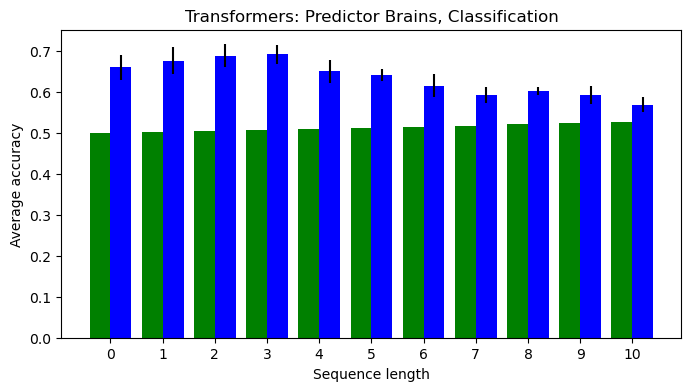

In [11]:
# Display the average accuracy and its standard error in a bar plot, for all sequence lengths. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))
x_coord = 0

# Iterate through all sequence lengths. 
for sequence_length in sequence_lengths:

    mean_score_baseline = df_summary_class.loc[sequence_length, 'mean_score_baseline']
    std_score_baseline = df_summary_class.loc[sequence_length, 'std_score_baseline']
    mean_score_test = df_summary_class.loc[sequence_length, 'mean_score_test']
    std_score_test = df_summary_class.loc[sequence_length, 'std_score_test']

    axes.bar(x_coord - 0.2, mean_score_baseline, width = 0.4, color = 'green')
    axes.errorbar(x_coord - 0.2, mean_score_baseline, yerr = std_score_baseline / np.sqrt(len(subjects)), fmt = 'None', color = 'black')
    axes.bar(x_coord + 0.2, mean_score_test, width = 0.4, color = 'blue')
    axes.errorbar(x_coord + 0.2, mean_score_test, yerr = std_score_test / np.sqrt(len(subjects)), fmt = 'None', color = 'black')
    x_coord = x_coord + 1

axes.set_xticks(range(len(sequence_lengths)), labels = sequence_lengths)
axes.set_xlabel('Sequence length')
axes.set_ylabel('Average accuracy')
axes.set_title('Transformers: Predictor Brains, Classification');

In [12]:
# Define the sequence length. 
selected_sequence_length = 5

# Retrieve the results for the selected sequence length. 
dict_models_pb_class = dict_sequences_class[selected_sequence_length]['models']
dict_history_pb_class = dict_sequences_class[selected_sequence_length]['history']
dict_predictions_pb_class = dict_sequences_class[selected_sequence_length]['predictions']
df_summary_pb_class = dict_sequences_class[selected_sequence_length]['summary']

In [13]:
# Display the results. 
print('Transformers: Predictor Brains, Classification')
df_summary_pb_class

Transformers: Predictor Brains, Classification


,loss_train,loss_valid,loss_test,score_train,score_valid,score_test,score_baseline,above_baseline,X_tr.shape,X_va.shape,X_te.shape,y_tr.shape,y_va.shape,y_te.shape
sub-xp101,0.365831,0.814507,0.805188,0.841026,0.574359,0.610256,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp103,0.333627,0.615879,0.718050,0.856410,0.687180,0.600000,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp104,0.297232,0.511461,0.571343,0.866667,0.753846,0.671795,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp105,0.482821,0.649720,0.719117,0.753846,0.635897,0.641026,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp106,0.308177,0.718357,0.731627,0.876923,0.646154,0.625641,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp107,0.409458,0.702276,0.670463,0.794872,0.558974,0.630769,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp108,0.383843,0.576974,0.501670,0.805128,0.682051,0.748718,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp109,0.457013,0.757552,0.638465,0.784615,0.517949,0.635897,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"
sub-xp110,0.434879,0.777584,0.713729,0.825641,0.456410,0.605128,0.512821,True,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 2)","(195, 2)","(195, 2)"


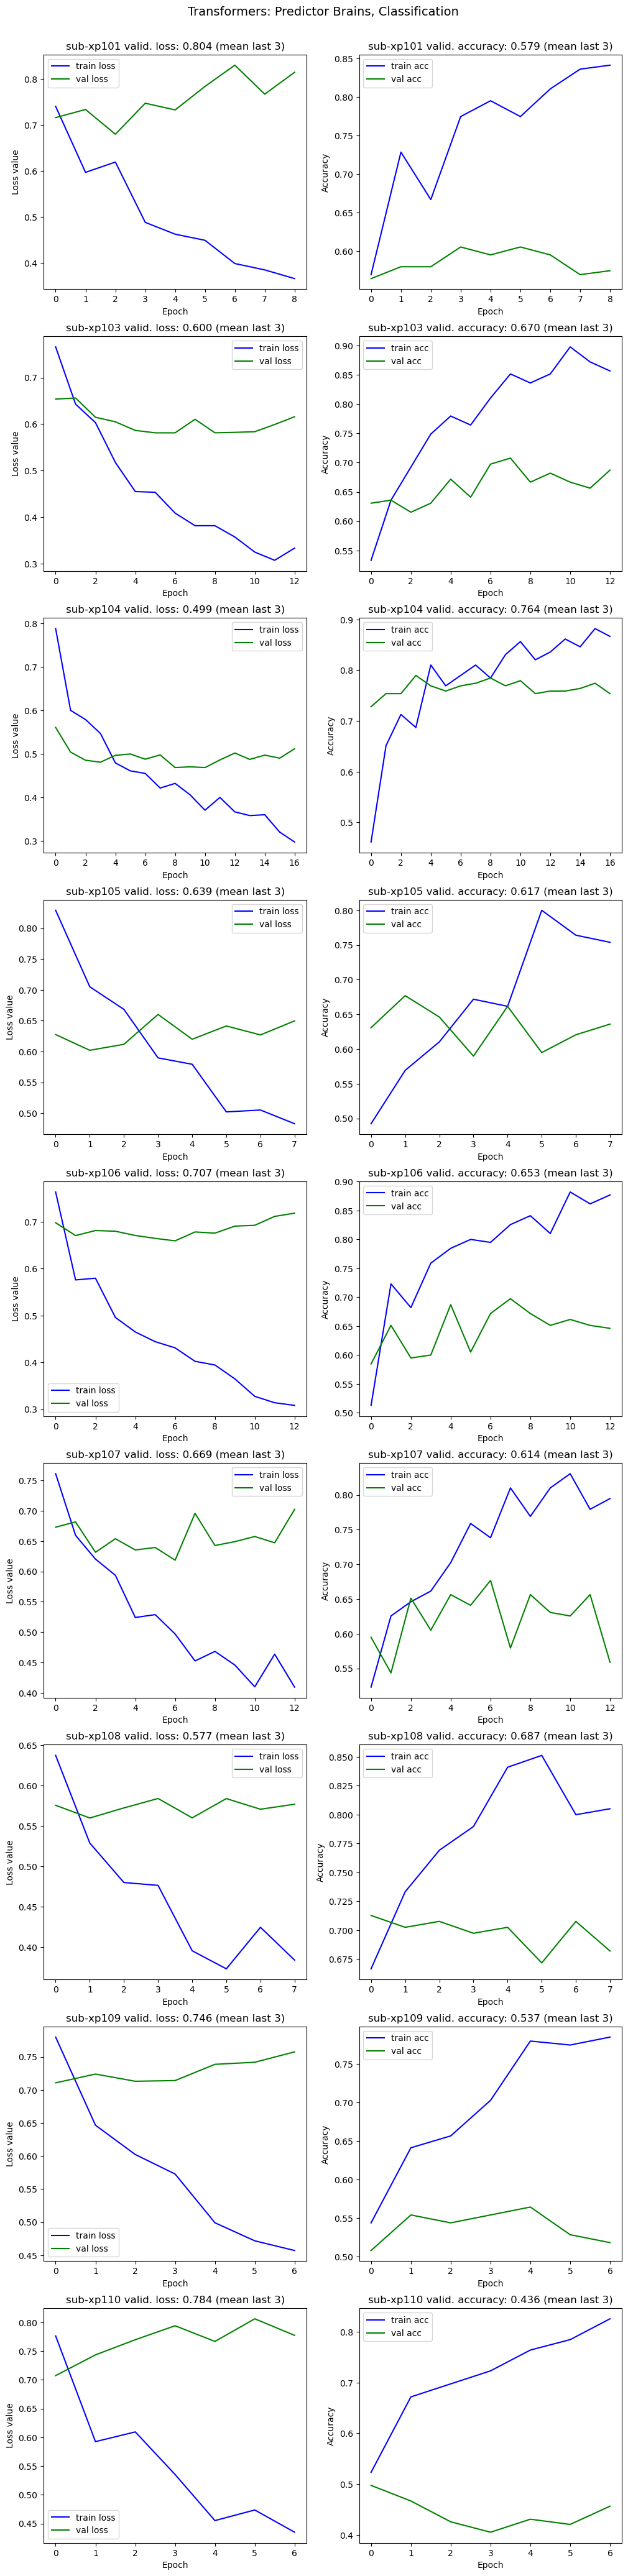

In [14]:
# Display the results. 
plot_neural_network_classification(dict_history_pb_class, title = 'Transformers: Predictor Brains, Classification')

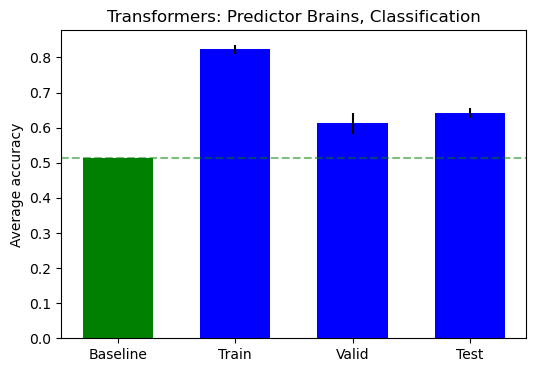

In [15]:
# Retrieve the average accuracy and the standard error of the accuracy. 
acc = [df_summary_pb_class['score_baseline'].mean(), 
       df_summary_pb_class['score_train'].mean(), 
       df_summary_pb_class['score_valid'].mean(), 
       df_summary_pb_class['score_test'].mean()]
acc_se = [np.std(df_summary_pb_class['score_baseline']) / np.sqrt(df_summary_pb_class['score_baseline'].shape[0]), 
          np.std(df_summary_pb_class['score_train']) / np.sqrt(df_summary_pb_class['score_train'].shape[0]), 
          np.std(df_summary_pb_class['score_valid']) / np.sqrt(df_summary_pb_class['score_valid'].shape[0]), 
          np.std(df_summary_pb_class['score_test']) / np.sqrt(df_summary_pb_class['score_test'].shape[0])]

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average accuracy')
axes.set_title('Transformers: Predictor Brains, Classification');

## **2. Regression**

- **Task**: We train a transformer model on our regression task of interest, on all subjects except sub-xp102 who has a missing condition. 

- **Model**: We use mostly the same model than for the classification task, but with the Adam optimizer and the Mean Squared Error (MSE) loss. Our objective is to minimize the regression Mean Absolute Error (MAE). Again, regarding the features, we experiment with different sequence lengths. 

- **Strategy**: The Predictor Brains strategy is defined as in the classification task. 

- **Results**: The transformer model typically beats the baseline for the train set, but stays over the baseline level for the validation set and the test set, indicating a lack of generalization. In contrast with the other neural network models, the predictions show some variance and do not remain close to the baseline. 

In [16]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [17]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [18]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [19]:
# Define a function to run a transformer model for the Predictor Brains strategy, for a regression task. 
def run_transformer_predictor_brains_regression(NeuralNetworkModel, dict_features_basis, dict_targets_basis, dict_baseline_basis, selected_sequence_length):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the general features of the train set, validation set, and test set. 
        X_tr_basis = dict_features_basis[subject]['eegfmriNF']
        X_va_basis = dict_features_basis[subject]['eegNF']
        X_te_basis = dict_features_basis[subject]['fmriNF']

        # Retrieve the general targets of the train set, validation set, and test set. 
        Y_tr_basis = dict_targets_basis[subject]['eegfmriNF']
        Y_va_basis = dict_targets_basis[subject]['eegNF']
        Y_te_basis = dict_targets_basis[subject]['fmriNF']

        # Retrieve the general baseline of the train set. 
        Baseline_basis = dict_baseline_basis[subject]['eegfmriNF']

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_basis_standardized = scaler.fit_transform(X_tr_basis)
        X_va_basis_standardized = scaler.transform(X_va_basis)
        X_te_basis_standardized = scaler.transform(X_te_basis)

        # Define the particular features arrays. 
        X_tr_standardized = np.zeros((nb_scans_total - selected_sequence_length, selected_sequence_length + 1, X_tr_basis_standardized.shape[1]))
        X_va_standardized = np.zeros((nb_scans_total - selected_sequence_length, selected_sequence_length + 1, X_va_basis_standardized.shape[1]))
        X_te_standardized = np.zeros((nb_scans_total - selected_sequence_length, selected_sequence_length + 1, X_te_basis_standardized.shape[1]))
        for scan in range(nb_scans_total - selected_sequence_length):
            for time_step in range(selected_sequence_length + 1):
                X_tr_standardized[scan, time_step, :] = X_tr_basis_standardized[scan + time_step, :].ravel()
                X_va_standardized[scan, time_step, :] = X_va_basis_standardized[scan + time_step, :].ravel()
                X_te_standardized[scan, time_step, :] = X_te_basis_standardized[scan + time_step, :].ravel()

        # Define the particular targets arrays. 
        Y_tr = Y_tr_basis[selected_sequence_length:]
        Y_va = Y_va_basis[selected_sequence_length:]
        Y_te = Y_te_basis[selected_sequence_length:]

        # Define the particular baseline array. 
        Baseline = Baseline_basis[selected_sequence_length:]

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, beta_1 = 0.8)
        PredictorBrain.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.MeanAbsoluteError()])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 30, 
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test score. 
        (mse_test, mae_test) = PredictorBrain.evaluate(X_te_standardized, Y_te, batch_size = batch_size)

        # Compute the predictions from the neural network, and compute the accuracy from these predictions. 
        Y_pred = PredictorBrain.predict(X_te_standardized)

        # Evaluate the performance metrics. 
        mse_baseline = MSE(Y_te, Baseline)
        mae_baseline = MAE(Y_te, Baseline)
        rss_baseline = RSS(Y_te, Baseline)
        mse_model = MSE(Y_te, Y_pred)
        mae_model = MAE(Y_te, Y_pred)
        rss_model = RSS(Y_te, Y_pred)
        r2_model = 1 - (rss_model / rss_baseline)

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'mse_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'mse_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'mse_test'] = mse_test
        df_summary.loc[subject, 'mae_train'] = NeuralNetworkHistory.history['mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_valid'] = NeuralNetworkHistory.history['val_mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_test'] = mae_test
        df_summary.loc[subject, 'mae_baseline'] = mae_baseline
        df_summary.loc[subject, 'r2_model'] = r2_model
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'Y_tr.shape'] = str(Y_tr.shape)
        df_summary.loc[subject, 'Y_va.shape'] = str(Y_va.shape)
        df_summary.loc[subject, 'Y_te.shape'] = str(Y_te.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = Y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [20]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_regression(dict_history_reg, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_reg[subject]

        # Plot MSE values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train MSE', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val MSE', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. MSE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('MSE')
        axes[subject_index, 0].legend()

        # Plot MAE values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['mean_absolute_error'], label = 'train MAE', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_mean_absolute_error'], label = 'val MAE', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. MAE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_mean_absolute_error'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('MAE')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [21]:
# Define a function to build a transformer model. 
def build_transformer_regression(transformer_input_shape, print_summary = True):
    
    # Define the random seed and inputs. 
    tf.random.set_seed(0)
    use_conv1d = False # We can use either Dense or Conv1D layers in the Feedforward layers section. 
    inputs = tf.keras.Input(shape = transformer_input_shape)
    x = inputs

    # Iterate through several blocks. 
    for block_index in range(2):

        # Normalization and attention layers. 
        x = tf.keras.layers.LayerNormalization(epsilon = 0.00001)(inputs)
        x = tf.keras.layers.MultiHeadAttention(
            key_dim = 256, num_heads = 8, dropout = 0.25
        )(x, x)
        x = tf.keras.layers.Dropout(0.25)(x)
        res = x + inputs

        # Feedforward layers. 
        x = tf.keras.layers.LayerNormalization(epsilon = 0.00001)(res)
        if use_conv1d == True:
            x = tf.keras.layers.Conv1D(filters = 8, kernel_size = 1, activation = tf.keras.activations.relu)(x)
            x = tf.keras.layers.Dropout(0.25)(x)
            x = tf.keras.layers.Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)
        else:
            x = tf.keras.layers.Dense(units = 512, activation = tf.keras.activations.relu)(x)
            x = tf.keras.layers.Dense(units = inputs.shape[-1])(x)
            x = tf.keras.layers.Dropout(0.25)(x)
        x = x + res

    # Dense layer. 
    x = tf.keras.layers.GlobalAveragePooling1D(data_format = 'channels_last')(x)
    x = tf.keras.layers.Dense(units = 128, activation = tf.keras.activations.relu)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer. 
    outputs = tf.keras.layers.Dense(
        units = dict_targets_basis[subject]['eegfmriNF'].shape[1]
        )(x)
    NeuralNetworkModel = tf.keras.Model(inputs, outputs)

    # Print network summary. 
    if print_summary:
        NeuralNetworkModel.summary()

    return NeuralNetworkModel

In [22]:
# Run the transformer for different sequence lengths. 
dict_sequences_reg = dict()
df_summary_reg = pd.DataFrame()
sequence_lengths = list(range(11))

# Iterate through all sequence lengths. 
for sequence_length in sequence_lengths:

    # Display current sequence length. 
    print('Sequence length: ' + str(sequence_length))

    # Define the sequence dictionary. 
    dict_sequences_reg[sequence_length] = dict()

    # Compute the shape of the features for the transformer. 
    transformer_input_shape = (sequence_length + 1, dict_features_basis[subject]['eegfmriNF'].shape[1])

    # Define the transformer model. 
    NeuralNetworkModel = build_transformer_regression(transformer_input_shape, print_summary = True)

    # Run the transformer model. 
    dict_models_pb_reg, dict_history_pb_reg, dict_predictions_pb_reg, df_summary_pb_reg = run_transformer_predictor_brains_regression(NeuralNetworkModel, 
                                                                                                                                      dict_features_basis, 
                                                                                                                                      dict_targets_basis, 
                                                                                                                                      dict_baseline_basis, 
                                                                                                                                      sequence_length)

    # Store the results. 
    dict_sequences_reg[sequence_length]['models'] = dict_models_pb_reg
    dict_sequences_reg[sequence_length]['history'] = dict_history_pb_reg
    dict_sequences_reg[sequence_length]['predictions'] = dict_predictions_pb_reg
    dict_sequences_reg[sequence_length]['summary'] = df_summary_pb_reg
    df_summary_reg.loc[sequence_length, 'mean_mae_test'] = df_summary_pb_reg['mae_test'].mean()
    df_summary_reg.loc[sequence_length, 'std_mae_test'] = np.std(df_summary_pb_reg['mae_test'])
    df_summary_reg.loc[sequence_length, 'mean_mae_baseline'] = df_summary_pb_reg['mae_baseline'].mean()
    df_summary_reg.loc[sequence_length, 'std_mae_baseline'] = np.std(df_summary_pb_reg['mae_baseline'])

Sequence length: 0
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1, 378)]     0           []                               
                                                                                                  
 layer_normalization_46 (LayerN  (None, 1, 378)      756         ['input_12[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_23 (Multi  (None, 1, 378)      3103098     ['layer_normalization_46[0][0]', 
 HeadAttention)                                                   'layer_normalization_46[0][0]'] 
                                                                        

In [23]:
# Display the results for all sequence lengths. 
df_summary_reg

,mean_mae_test,std_mae_test,mean_mae_baseline,std_mae_baseline
0,0.919917,0.195751,0.791789,0.014500
1,0.894532,0.146941,0.790484,0.013587
2,0.864980,0.099417,0.789776,0.013354
3,0.855638,0.092802,0.788732,0.013125
4,0.863138,0.109251,0.787756,0.012476
5,0.844747,0.085034,0.786376,0.012516
6,0.822988,0.049211,0.785394,0.012394
7,0.833842,0.069843,0.784626,0.011924
8,0.834164,0.061845,0.783659,0.011851
9,0.838629,0.086638,0.783364,0.011531


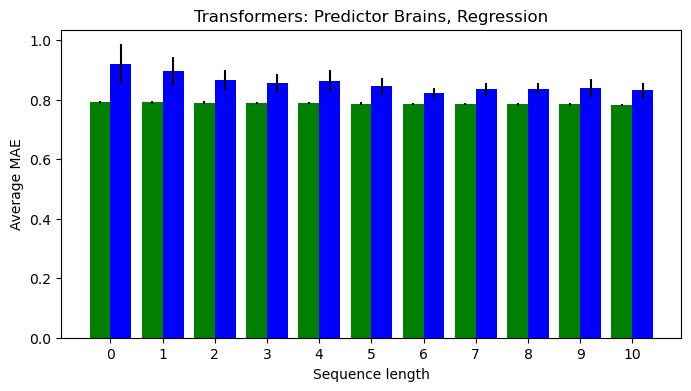

In [24]:
# Display the average MAE and its standard error in a bar plot, for all sequence lengths. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))
x_coord = 0

# Iterate through all sequence lengths. 
for sequence_length in sequence_lengths:

    mean_mae_baseline = df_summary_reg.loc[sequence_length, 'mean_mae_baseline']
    std_mae_baseline = df_summary_reg.loc[sequence_length, 'std_mae_baseline']
    mean_mae_test = df_summary_reg.loc[sequence_length, 'mean_mae_test']
    std_mae_test = df_summary_reg.loc[sequence_length, 'std_mae_test']

    axes.bar(x_coord - 0.2, mean_mae_baseline, width = 0.4, color = 'green')
    axes.errorbar(x_coord - 0.2, mean_mae_baseline, yerr = std_mae_baseline / np.sqrt(len(subjects)), fmt = 'None', color = 'black')
    axes.bar(x_coord + 0.2, mean_mae_test, width = 0.4, color = 'blue')
    axes.errorbar(x_coord + 0.2, mean_mae_test, yerr = std_mae_test / np.sqrt(len(subjects)), fmt = 'None', color = 'black')
    x_coord = x_coord + 1

axes.set_xticks(range(len(sequence_lengths)), labels = sequence_lengths)
axes.set_xlabel('Sequence length')
axes.set_ylabel('Average MAE')
axes.set_title('Transformers: Predictor Brains, Regression');

In [25]:
# Define the sequence length. 
selected_sequence_length = 5

# Retrieve the results for the selected sequence length. 
dict_models_pb_reg = dict_sequences_reg[selected_sequence_length]['models']
dict_history_pb_reg = dict_sequences_reg[selected_sequence_length]['history']
dict_predictions_pb_reg = dict_sequences_reg[selected_sequence_length]['predictions']
df_summary_pb_reg = dict_sequences_reg[selected_sequence_length]['summary']

In [26]:
# Display the results. 
print('Transformers: Predictor Brains, Regression')
df_summary_pb_reg

Transformers: Predictor Brains, Regression


,mse_train,mse_valid,mse_test,mae_train,mae_valid,mae_test,mae_baseline,r2_model,X_tr.shape,X_va.shape,X_te.shape,Y_tr.shape,Y_va.shape,Y_te.shape
sub-xp101,0.730170,1.638977,1.740803,0.680039,0.976728,1.024083,0.761400,-0.906193,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp103,0.850311,1.056911,0.995394,0.733430,0.827065,0.797356,0.793431,-0.025330,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp104,0.675038,0.842530,0.968469,0.650138,0.730117,0.780435,0.768766,-0.052821,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp105,0.668002,1.334058,1.516232,0.654027,0.911943,0.979222,0.788395,-0.592133,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp106,0.726525,0.951263,1.013496,0.681491,0.781978,0.814496,0.793431,-0.055243,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp107,0.753505,1.024073,0.986308,0.691918,0.812200,0.793250,0.782540,-0.034803,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp108,0.773165,1.023973,0.995698,0.696932,0.817896,0.804864,0.799883,-0.015894,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp109,0.788475,1.029254,0.987001,0.707142,0.815945,0.799300,0.798910,-0.018964,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"
sub-xp110,0.771346,1.011790,0.995083,0.699355,0.809414,0.809715,0.790629,-0.043480,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 17)","(195, 17)","(195, 17)"


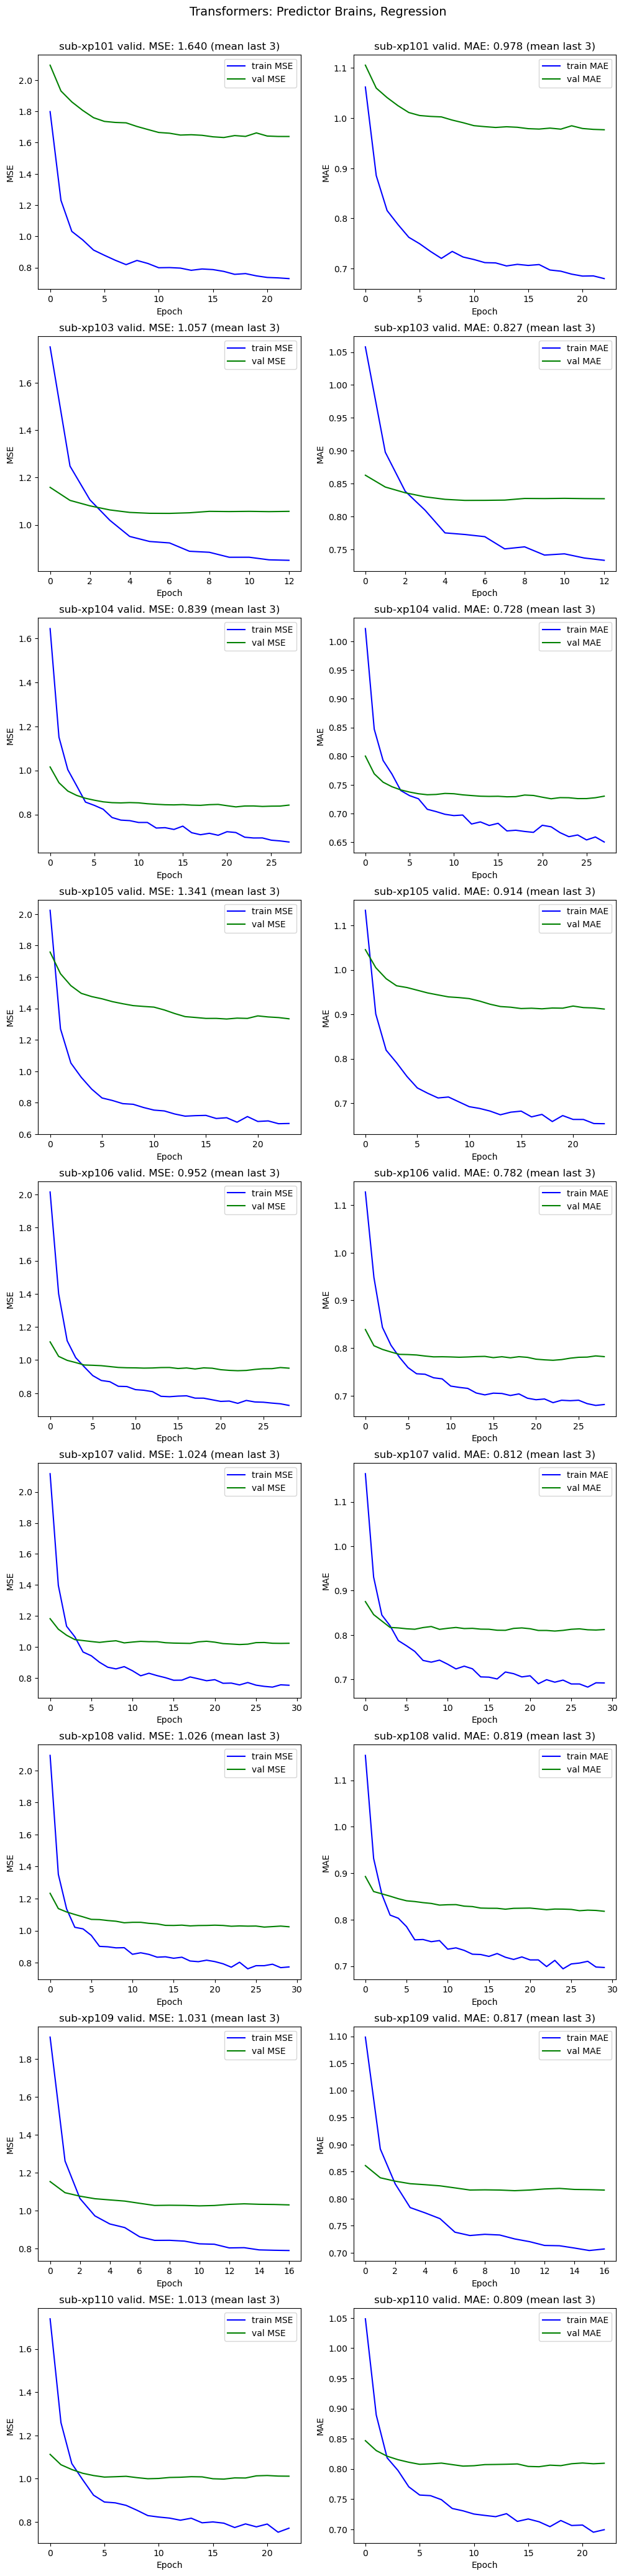

In [27]:
# Display the results. 
plot_neural_network_regression(dict_history_pb_reg, title = 'Transformers: Predictor Brains, Regression')

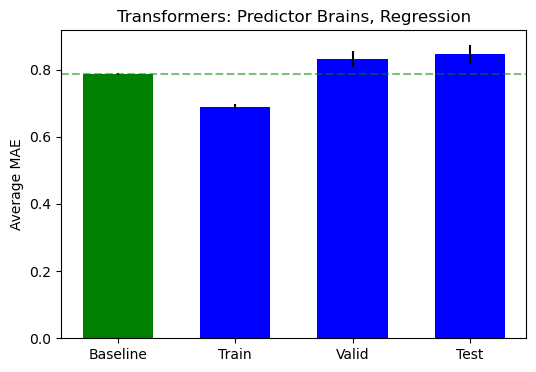

In [28]:
# Retrieve the average MAE and the standard error of the MAE. 
acc = [df_summary_pb_reg['mae_baseline'].mean(), 
       df_summary_pb_reg['mae_train'].mean(), 
       df_summary_pb_reg['mae_valid'].mean(), 
       df_summary_pb_reg['mae_test'].mean()]
acc_se = [np.std(df_summary_pb_reg['mae_baseline']) / np.sqrt(df_summary_pb_reg['mae_baseline'].shape[0]), 
          np.std(df_summary_pb_reg['mae_train']) / np.sqrt(df_summary_pb_reg['mae_train'].shape[0]), 
          np.std(df_summary_pb_reg['mae_valid']) / np.sqrt(df_summary_pb_reg['mae_valid'].shape[0]), 
          np.std(df_summary_pb_reg['mae_test']) / np.sqrt(df_summary_pb_reg['mae_test'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average MAE')
axes.set_title('Transformers: Predictor Brains, Regression');

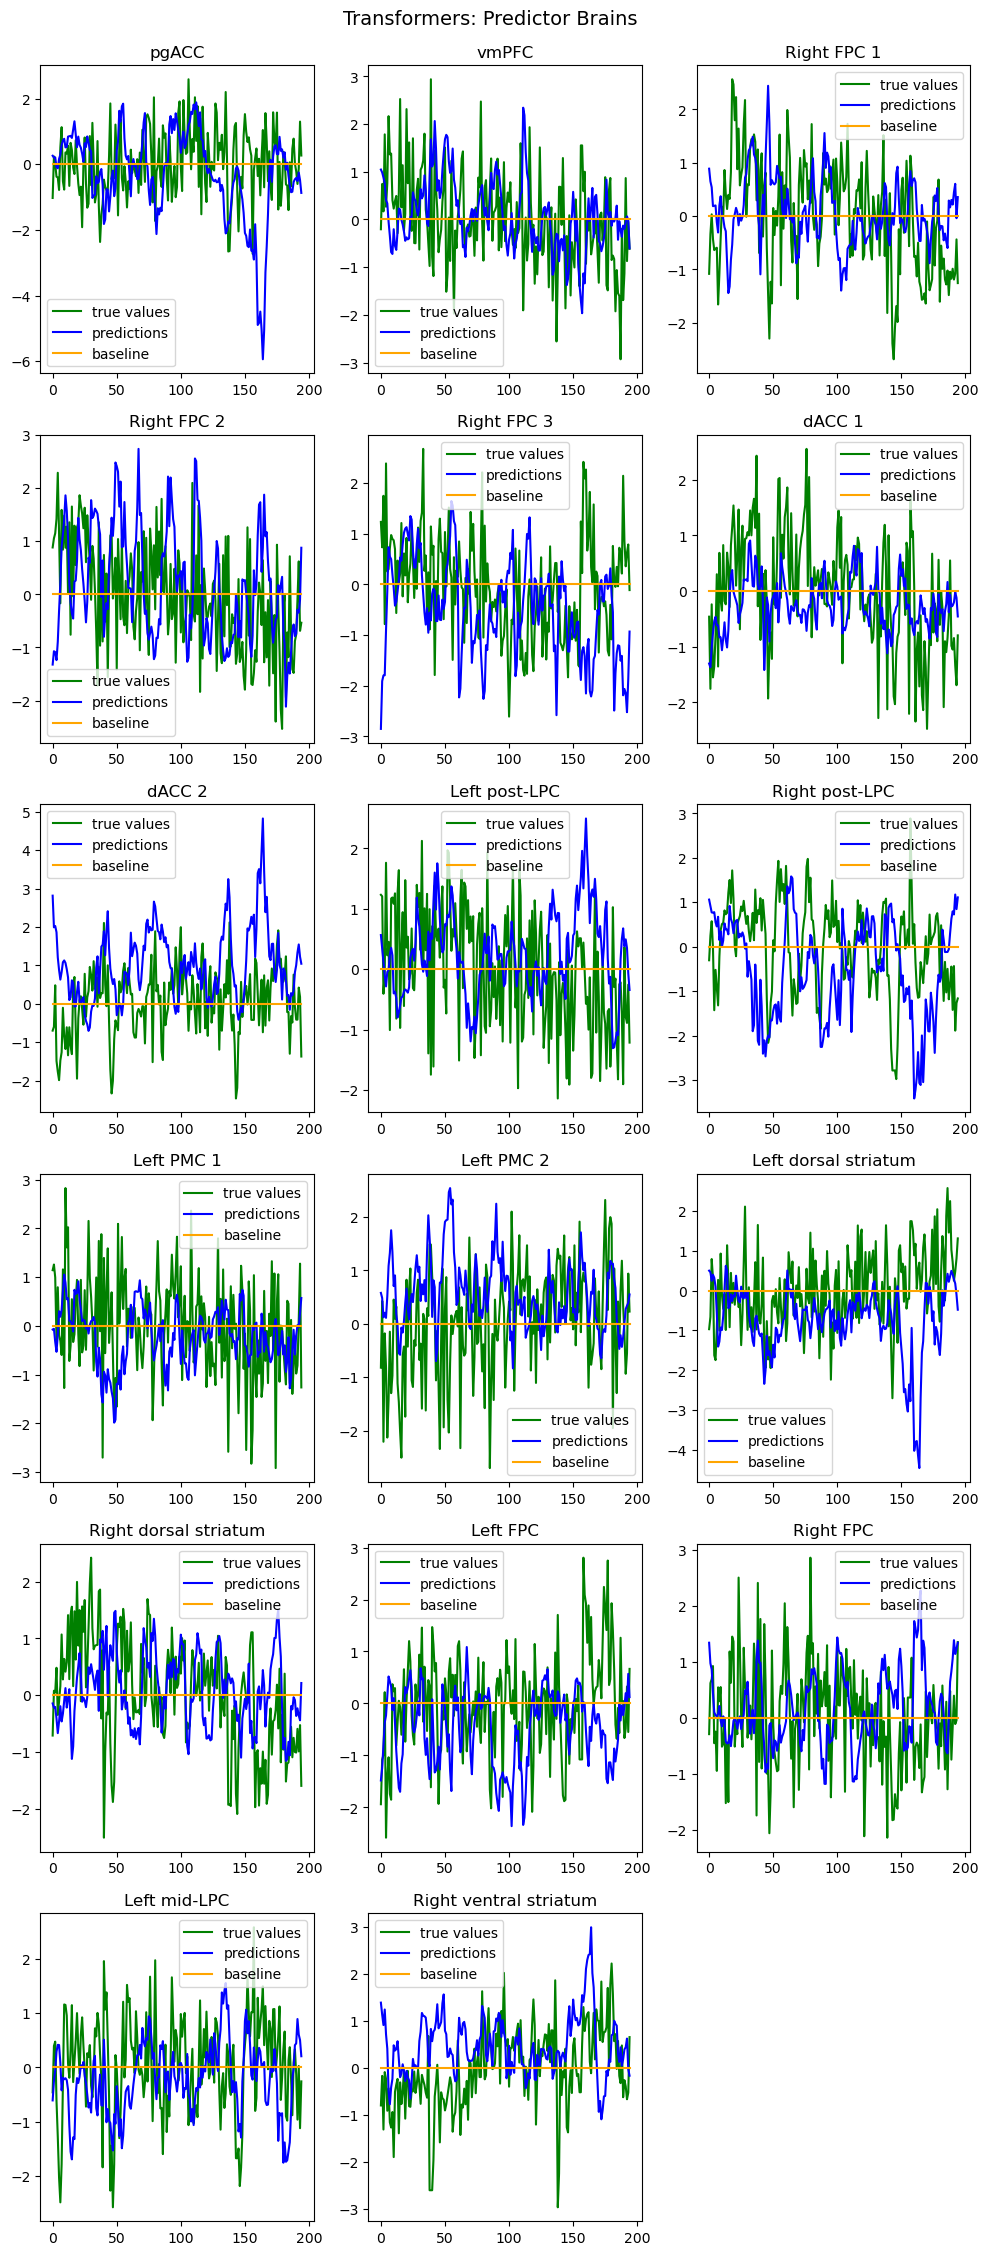

In [29]:
# Plot the true values, the predictions, and the baseline for all the targets voxels. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 28))
fig.suptitle('Transformers: Predictor Brains', fontsize = 14, y = 0.9)
subject = subjects[0]

# Iterate through all target voxels. 
for target_index in range(len(targets)):

    # Retrieve the true values, the predictions, and the baseline for the selected subject and sequence length. 
    Y_te = dict_targets_sequence[subject]['fmriNF'][:, target_index]
    Y_pred = dict_predictions_pb_reg[subject][:, target_index]
    Baseline = dict_baseline_sequence[subject]['eegfmriNF'][:, target_index]

    # Compute the row and column indexes. 
    row_index = target_index // 3
    column_index = target_index % 3

    # Plot the true values, the predictions, and the baseline. 
    axes[row_index, column_index].plot(Y_te,  color = 'green', label = 'true values')
    axes[row_index, column_index].plot(Y_pred,  color = 'blue', label = 'predictions')
    axes[row_index, column_index].plot(Baseline,  color = 'orange', label = 'baseline')
    axes[row_index, column_index].legend()
    axes[row_index, column_index].set_title(targets[target_index])

# Hide empty subplot. 
axes[5, 2].set_visible(False)

In [30]:
# Save the regression models into a Pickle file. 
with open(results_path + 'dict_models_transformers_pb_reg.p', 'wb') as file:
    pickle.dump(dict_models_pb_reg, file)